# 3. Modèle SIFT-Classification

* 3.1 Principes et démarche
* 3.2 Rappel des images augmentées et analyse "equalization" des images
* 3.3 Détermination des features via SIFT
* 3.4 Classification
* 3.5 Amélioration - Fichier Test bounding box
* 3.6 Amélioration - Equalization des images (gris) pour améliorer la création des features
* 3.7 Amélioration - Test de RootSIFT pour améliorer la création des features



------------

# 3.1 Principes et démarche


### Principes
Elaborer une classification de features crées à partir de descripteurs SIFT :
* Détermination des descripteurs SIFT de chaque image
* Création de clusters KMeans des descripteurs
* Détermination des features de chaque image (histogramme des descripteurs selon les clusters)
* Réduction de dimension des features
* Classification en gridsearchCV = test de différents alogorithmes et optimisation de l'algorithme sélectionné


### Démarche
* Elaboration d'un premier modèle selon les principes présentés
* Test d'améliorations de l'algorithme sélectionné (bounding box images Test, equalisation images Train et Test, RootSIFT)


### Critères de décision
* Le choix du nombre de clusters a été déterminé par de premières simulations (non formalisées dans ce NoteBook) et la limite matérielle, en particulier le RAM du PC (16 Go) => choix de k = 5000
* Le critère de décision de l'algorithme et son optimisation s'appuiera sur la mesure de l'accuracy score




-----------

# 3.2 Rappel des images augmentées et analyse "equalization" des images

### Actions
* Récupération des données Train et Test
* Rappel des images Train augmentées
* Rappel des images Test "bounding box"
* Descripteurs SIFT avec ou sans "equalization" des images



---------

### Récupération des données Train et Test


In [0]:
# Import des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv

import imutils
import os
import scipy.io
from scipy.cluster.vq import *
from scipy import ndimage, misc
from sklearn.preprocessing import StandardScaler

import pickle

with open("D:/ML_Datasets/Images/Dogs/Sauv/image_2class_Train.py", "rb") as fp:   # Unpickling
    image_2class_Train = pickle.load(fp)
    
with open("D:/ML_Datasets/Images/Dogs/Sauv/y_2class_Train.py", "rb") as fp:   # Unpickling
    y_2class_Train = pickle.load(fp)
    
    
with open("D:/ML_Datasets/Images/Dogs/Sauv/image_2class_Test.py", "rb") as fp:   # Unpickling
    image_2class_Test = pickle.load(fp)
    
with open("D:/ML_Datasets/Images/Dogs/Sauv/image_2class_Test_box.py", "rb") as fp:   # Unpickling
    image_2class_Test_box = pickle.load(fp)
    
with open("D:/ML_Datasets/Images/Dogs/Sauv/y_2class_Test.py", "rb") as fp:   # Unpickling
    y_2class_Test = pickle.load(fp)
    


-----------------

### Rappel des images Train augmentées


Image initiale : 
---------------


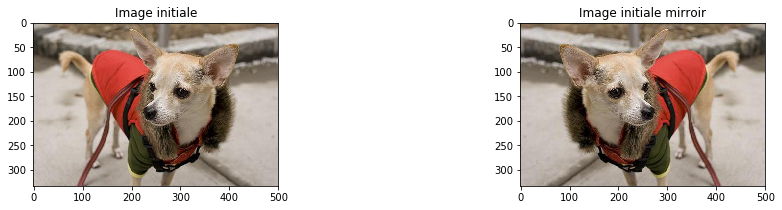


Image bounding box (fichier annotation) : 
----------------------------------------


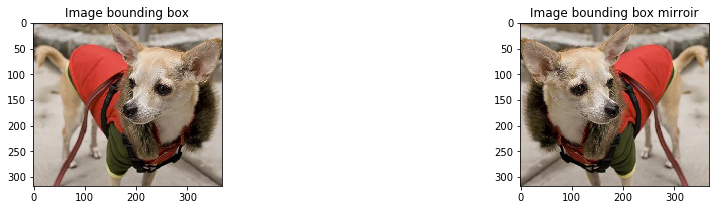

In [0]:
# Images Train
ind = 2
fig = plt.figure(figsize=(16, 3))
print("Image initiale : ")
print("---------------")
img = cv.imread(image_2class_Train[ind])
img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('Image initiale')
ax1.imshow(img)

img = cv.imread(image_2class_Train[ind+200])
img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Image initiale mirroir')
ax2.imshow(img)
plt.show()

fig = plt.figure(figsize=(16, 3))
print()
print("Image bounding box (fichier annotation) : ")
print("----------------------------------------")
img = cv.imread(image_2class_Train[ind+400])
img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('Image bounding box')
ax1.imshow(img)

img = cv.imread(image_2class_Train[ind+600])
img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Image bounding box mirroir')
ax2.imshow(img)
plt.show()



-----------------

### Rappel des images Test "bounding box"

Image Test : 
----------


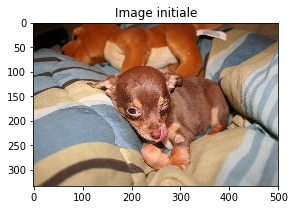

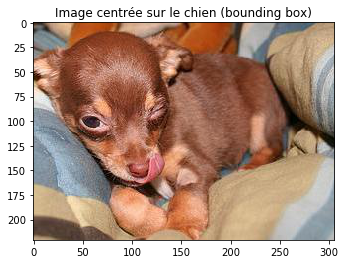

In [0]:
import matplotlib.cm as cm

# Image Test
ind = 0
fig = plt.figure(figsize=(16, 3))
print("Image Test : ")
print("----------")
img = cv.imread(image_2class_Test[ind])
img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
# ax1 = fig.add_subplot(1,2,1)
plt.title('Image initiale')
plt.imshow(img)
plt.show()

# Image Test bounding box
img = cv.imread(image_2class_Test_box[ind])
img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
# ax2 = fig.add_subplot(1,2,2)
plt.title('Image centrée sur le chien (bounding box)')
plt.imshow(img)
plt.show()



------------------

### Descripteurs SIFT avec ou sans "equalization" des images


<b>Analyse :</b>
* La transformation des images par equalization apporte un meilleur contraste et génère des keypoints supplémentaires
* Il est donc opportun de tester cette approche pour améliorer le modèle (CF chapitre 3.6)


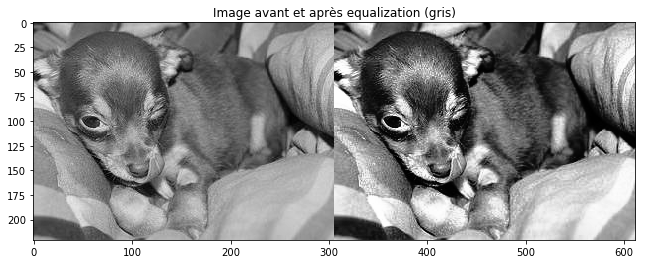

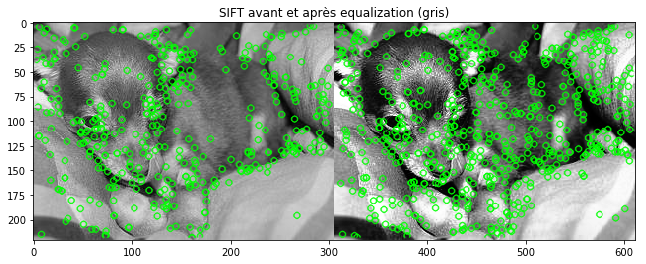

In [0]:
# Principe des keypoints et descriptors

fig = plt.figure(figsize=(12, 4))
# Equalizer
img_gray = cv.cvtColor(img,cv.COLOR_RGB2GRAY)
img_equ = cv.equalizeHist(img_gray)
res = np.hstack((img_gray,img_equ))
plt.title('Image avant et après equalization (gris)')
plt.imshow(res, cmap=cm.gray)
plt.show()

# SIFT detector
fig = plt.figure(figsize=(12, 4))
img_gray = cv.cvtColor(img,cv.COLOR_RGB2GRAY)

sift = cv.xfeatures2d.SIFT_create()
keypoints, descriptors = sift.detectAndCompute(img_gray, None)
img2 = cv.drawKeypoints(img_gray, keypoints, None, color=(0,255,0), flags=0) 

sift = cv.xfeatures2d.SIFT_create()
keypoints, descriptors = sift.detectAndCompute(img_equ, None)
img2_equ = cv.drawKeypoints(img_equ, keypoints, None, color=(0,255,0), flags=0) 

res = np.hstack((img2,img2_equ))
plt.title('SIFT avant et après equalization (gris)')
plt.imshow(res)
plt.show()



-------

# 3.3 Détermination des features via SIFT

### Actions
* Détermination des features Train (descriptors, KMeans, features)
* Détermination des features Test (descriptors, features)
* Sauvegarde des features



---------

### Fonctions de détermination des keypoints, descriptors et features

In [0]:
# Fonction de détermination des descripteurs
import time    
    
def descriptors_SIFT_fct(list_images, equalization=False) :
    temps1=time.time()
    # Initialisation du SIFT detector
    sift = cv.xfeatures2d.SIFT_create()
    eps=1e-7
    des_list = []

    for image_num in range(len(list_images)) :
        # if image_num%100 == 0 :
        #     print(image_num)
        
        image = cv.imread(list_images[image_num])
        img_gray = cv.cvtColor(image,cv.COLOR_BGR2GRAY)
        if equalization == True :
            img_gray = cv.equalizeHist(img_gray)

        # Détection des keypoints and calcul des descriptors avec SIFT
        keypoints, descriptors = sift.detectAndCompute(img_gray, None)
        des_list.append(descriptors)
  
    descriptors = des_list[0]
    for descriptor in des_list[1:] :
        descriptors = np.vstack((descriptors, descriptor))  # Stacking the descriptors
        
    temps2=time.time()-temps1
    print("temps de traitement SIFT descriptor : ", "%15.2f" % temps2, "secondes")
    
    return des_list, descriptors


def features_fct(k, voc, des_list) :
    temps1=time.time()
    # Calcul de l'histogramme des features
    im_features = np.zeros((len(des_list), k), "float32")
    for i in range(len(des_list)):
        words, distance = vq(des_list[i],voc)
        # if i%100 == 0 :
        #     print(i)

        for w in words:
            im_features[i][w] += 1
    
    temps2=time.time()-temps1
    print("temps de traitement SIFT features   : ", "%15.2f" % temps2, "secondes")
    
    return im_features



---------
### Détermination des features Train

In [0]:
""" Détermination des features Train """
import time 

# Initialisation des images
list_images = image_2class_Train

# Calcul des descriptors
des_list, descriptors = descriptors_SIFT_fct(list_images, equalization=False)

# K-means clustering
temps1=time.time()
k = 5000  # Nombre de clusters
voc, variance = kmeans(descriptors, k, 1)
temps2=time.time()-temps1
print("temps de traitement SIFT KMeans     : ", "%15.2f" % temps2, "secondes")

# Calcul de l'histogramme des features
im_features_Train = features_fct(k, voc, des_list)


temps de traitement SIFT descriptor :            79.00 secondes
temps de traitement SIFT KMeans     :          1269.51 secondes
temps de traitement SIFT features   :            19.75 secondes



------------
### Détermination des features Test

In [0]:
""" Détermination des features Test """

# Initialisation des images
list_images = image_2class_Test

# Calcul des descriptors
des_list, descriptors = descriptors_SIFT_fct(list_images, equalization=False)

# Calcul de l'histogramme des features
im_features_Test = features_fct(k, voc, des_list)


temps de traitement SIFT descriptor :            13.55 secondes
temps de traitement SIFT features   :             5.92 secondes


In [0]:
""" Détermination des features Test_box """

# Initialisation des images
list_images = image_2class_Test_box

# Calcul des descriptors
des_list, descriptors = descriptors_SIFT_fct(list_images, equalization=False)

# Calcul de l'histogramme des features
im_features_Test_box = features_fct(k, voc, des_list)


temps de traitement SIFT descriptor :             9.97 secondes
temps de traitement SIFT features   :             4.52 secondes


In [0]:
import pickle

with open("D:/ML_Datasets/Images/Dogs/Sauv/im_features_Train.py", "wb") as fp:   
    pickle.dump(im_features_Train, fp)

with open("D:/ML_Datasets/Images/Dogs/Sauv/im_features_Test.py", "wb") as fp:  
    pickle.dump(im_features_Test, fp)

with open("D:/ML_Datasets/Images/Dogs/Sauv/im_features_Test_box.py", "wb") as fp:  
    pickle.dump(im_features_Test_box, fp)


In [0]:
import pickle

with open("D:/ML_Datasets/Images/Dogs/Sauv/im_features_Train.py", "rb") as fp:   # Unpickling
    im_features_Train = pickle.load(fp)
    
with open("D:/ML_Datasets/Images/Dogs/Sauv/im_features_Test.py", "rb") as fp:   # Unpickling
    im_features_Test = pickle.load(fp) 
    
with open("D:/ML_Datasets/Images/Dogs/Sauv/im_features_Test_box.py", "rb") as fp:   # Unpickling
    im_features_Test_box = pickle.load(fp)    


-----------


# 3.4 Classification
* 3.4.1 Préparation des données
* 3.4.2 Test de différents algorithmes et choix
* 3.4.3 Optimisation de l'algorithme sélectionné



---------

## 3.4.1 Preparation des données

* Standardisation des features et réduction de dimension
* Préparation des données Train et Test



-----

### Standardisation des features et réduction de dimension


In [0]:
""" Scaling """

# Scaling des features Train
stdSlr = StandardScaler().fit(im_features_Train)
X_train_s = stdSlr.transform(im_features_Train)

# Scaling des features Test
X_test_s = stdSlr.transform(im_features_Test)
X_test_box_s = stdSlr.transform(im_features_Test_box)


""" Réduction de dimension """
# Réduction de dimension d'une "sparse matrix" avec TruncatedSVD (équivalent à PCA)

from sklearn import decomposition

tr_svd = decomposition.TruncatedSVD(n_components=500,algorithm='randomized', n_iter=5, random_state=None, tol=0.0)
tr_svd.fit(X_train_s)
X_train_t = tr_svd.transform(X_train_s)

tr_svd_ratio = np.cumsum(tr_svd.explained_variance_ratio_)
print("Ratio cumulé : ", "%4.2f" % tr_svd_ratio.max())
# plt.plot(tr_svd_ratio)
# plt.show()

Ratio cumulé :  0.94



--------------

### Préparation des données Train et Test

In [0]:
# Préparation des données Train et Test

X_test_t = tr_svd.transform(X_test_s)
X_test_box_t = tr_svd.transform(X_test_box_s)

X_train = X_train_t
X_test = X_test_t
X_test_box = X_test_box_t

y_train = y_2class_Train
y_test = y_2class_Test




----------

## 3.4.2 Test de différents algorithmes et choix

### Actions
* Simulation des algorithmes candidats
* Comparaison des scores des algorithmes
* Choix d'un algorithme

### Décision
* L'algorithme "RidgeClassifier" obtient le meilleur score, il est choisi pour l'étape suivante d'optimisation



------------

### Fonction d'affichage de score

In [0]:
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import metrics

def f1_score_pond_fct(precision, recall, fscore, support, y_test) :

    nb_class0 = sum([1 for i in range(len(y_test)) if y_test[i] == 0])
    nb_class1 = sum([1 for i in range(len(y_test)) if y_test[i] == 1])
    f1_score_pond = (nb_class0*fscore[0] + nb_class1*fscore[1]) / len(y_test)
    # print("f1 score pondéré :", "%6.4f" % f1_score_pond)
    
    return f1_score_pond


### Test et comparaison des algorithmes candidats

In [0]:
from sklearn.model_selection import StratifiedKFold

# Création des folds pour la Cross-Validation
seed = 7
folds = StratifiedKFold(n_splits=3, shuffle=False, random_state=seed)
folds.split(X_train,y_train)


<generator object _BaseKFold.split at 0x000002997C3D7BA0>

In [0]:
import time 

def simu_algo_fct(clf) :
    temps1=time.time()
    print ("Simulation avec algorithme : ")
    print ("--------------------------")
    print (clf)
    print()
    # print ("-----------------------------------")

    param_grid = { } 
    clfCV = model_selection.GridSearchCV(clf, param_grid, cv=folds)
    clfCV.fit(X_train, y_train)
    y_pred = clfCV.predict(X_test)
    
    accuracy_score = metrics.accuracy_score(y_test, y_pred)
    
    # Calcul du f1 score pondéré
    precision, recall, fscore, support = metrics.precision_recall_fscore_support(y_test, y_pred)
    f1_score_pond = f1_score_pond_fct(precision, recall, fscore, support, y_test)
    print("accuracy score :", "%6.4f" % accuracy_score)
    print("f1 score       :", "%6.4f" % f1_score_pond)
    
    temps2=time.time()-temps1
    print ("Temps d'exécution = %5.2f" %temps2, "secondes")
    print (" ")
    print (" ")
    
    return accuracy_score, f1_score_pond, temps2
    

In [0]:
from sklearn import model_selection, linear_model, neural_network, neighbors, svm, tree, ensemble, naive_bayes

l_algos = [
            ['RidgeClassifier', linear_model.RidgeClassifier()],
            ['SVC', svm.SVC(kernel='linear')],
            ['MLPClassifier', neural_network.MLPClassifier()],
            ['KNeighborsClassifier', neighbors.KNeighborsClassifier()],
            ['LinearSVC - Crammer', svm.LinearSVC(multi_class="crammer_singer")], 
            ['LogisticRegression', linear_model.LogisticRegression()],    
            ['DecisionTreeClassifier', tree.DecisionTreeClassifier()],
            ['ExtraTreesClassifier', ensemble.ExtraTreesClassifier()],
            ['RandomForestClassifier',ensemble.RandomForestClassifier()],
            ['GradientBoostingClassifier', ensemble.GradientBoostingClassifier()],
            ['GaussianNB', naive_bayes.GaussianNB()],
            ['SGDClassifier', linear_model.SGDClassifier()],
            ['BaggingClassifier', ensemble.BaggingClassifier()],
            ['AdaBoostClassifier', ensemble.AdaBoostClassifier()]
          ]
 

tab_algo = []

for i in range(len(l_algos)) :
    clf = l_algos[i][1]
    accuracy_score, f1score, temps = simu_algo_fct(clf)
    tab_algo.append([accuracy_score, f1score, l_algos[i][0], temps])
    

Simulation avec algorithme : 
--------------------------
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='auto',
        tol=0.001)

accuracy score : 0.7810
f1 score       : 0.7838
Temps d'exécution =  0.06 secondes
 
 
Simulation avec algorithme : 
--------------------------
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

accuracy score : 0.7372
f1 score       : 0.7409
Temps d'exécution =  0.83 secondes
 
 
Simulation avec algorithme : 
--------------------------
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.

In [0]:
# Fonction de classification des algorithmes selon leur score

def report_algos_scores_fct(tab_algo) :
    
    algo_compared = sorted(tab_algo, reverse=True) 

    print("                  algorithme", "      accuracy_score ", "  f1score ", "temps exécution")
    print("                 -----------", "      -------------- ", "  ------- ", "---------------")
    for i in range(len(algo_compared)) :
        accuracy_score, f1score, algo, time = algo_compared[i]
        print ("%30s" % algo, "     ", "%7.3f" % accuracy_score, "      ", "%7.3f" % f1score, "     ", "%5.2f" %time)


In [0]:
# Classification des algorithmes selon leur score
report_algos_scores_fct(tab_algo)


                  algorithme       accuracy_score    f1score  temps exécution
                 -----------       --------------    -------  ---------------
               RidgeClassifier         0.781          0.784        0.06
                 MLPClassifier         0.781          0.784        2.09
            LogisticRegression         0.774          0.777        0.33
                 SGDClassifier         0.766          0.769        0.02
           LinearSVC - Crammer         0.759          0.763        0.94
    GradientBoostingClassifier         0.745          0.748        8.72
                           SVC         0.737          0.741        0.83
             BaggingClassifier         0.708          0.712        4.55
            AdaBoostClassifier         0.708          0.710        5.59
        RandomForestClassifier         0.664          0.669        0.27
        DecisionTreeClassifier         0.664          0.669        0.83
                    GaussianNB         0.628        


----------------------------------------

## 3.4.2 Optimisation de l'algorithme choisi

### Actions
* Tester différentes valeurs des hyperparamètres pour l'algorithme, via GridSearchCV
* Choisir les hyperparamètres optimisant le score

### Analyse
* L'optimum est pour la valeur 1000.0 de l'hyperparamètre "alpha"
* Les valeurs sont très proches pour les différentes valeurs de l'hyperparamètre


In [0]:
from sklearn import model_selection, linear_model

""" RidgeClassifier - GridsearchCV """

param_grid = {
                'alpha' : [ 0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
          }
print("Hyper-paramètres candidats :")
print("----------------------------")
print (param_grid)

rc = linear_model.RidgeClassifier(normalize=False)
# rc = linear_model.RidgeClassifier(alpha=1.0, fit_intercept=True, normalize=False, copy_X=True, max_iter=None, 
#                                   tol=0.001, class_weight=None, solver='auto', random_state=None)

rcCV = model_selection.GridSearchCV(rc, param_grid, cv=folds)
rcCV.fit(X_train, y_train)
y_pred_rcCV = rcCV.predict(X_test)

score_rcCV = rcCV.score(X_test,y_test)
print(" ")
print("Meilleur hyper-paramètre : ", rcCV.best_params_)
print("---------------------------")
print ("score           : ", "%6.3f" % score_rcCV)

# Calcul du f1 score pondéré
precision, recall, fscore, support = metrics.precision_recall_fscore_support(y_test, y_pred_rcCV)
f1_score_pond = f1_score_pond_fct(precision, recall, fscore, support, y_test)

score_SIFT_TrainStd_TestStd = score_rcCV

Hyper-paramètres candidats :
----------------------------
{'alpha': [1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]}
 
Meilleur hyper-paramètre :  {'alpha': 1000.0}
---------------------------
score           :   0.781



-------------


# 3.5 Amélioration - Fichier Test bounding box

### Action
* Prendre comme images du fichier Test les bounding box centrées sur les chiens

### Résultat
* le résultat est sensiblement amélioré (+ 3%)


In [0]:
X_test = X_test_box

In [0]:
from sklearn import model_selection, linear_model

""" RidgeClassifier - GridsearchCV """

param_grid = {
                'alpha' : [ 0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
          }
print("Hyper-paramètres candidats :")
print("----------------------------")
print (param_grid)

rc = linear_model.RidgeClassifier(normalize=False)
# rc = linear_model.RidgeClassifier(alpha=1.0, fit_intercept=True, normalize=False, copy_X=True, max_iter=None, 
#                                   tol=0.001, class_weight=None, solver='auto', random_state=None)

rcCV = model_selection.GridSearchCV(rc, param_grid, cv=folds)
rcCV.fit(X_train, y_train)
y_pred_rcCV = rcCV.predict(X_test)

score_rcCV = rcCV.score(X_test,y_test)
print(" ")
print("Meilleur hyper-paramètre : ", rcCV.best_params_)
print("---------------------------")
print ("score           : ", "%6.3f" % score_rcCV)

# Calcul du f1 score pondéré
precision, recall, fscore, support = metrics.precision_recall_fscore_support(y_test, y_pred_rcCV)
f1_score_pond = f1_score_pond_fct(precision, recall, fscore, support, y_test)

score_SIFT_TrainStd_TestBox = score_rcCV

Hyper-paramètres candidats :
----------------------------
{'alpha': [1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]}
 
Meilleur hyper-paramètre :  {'alpha': 1000.0}
---------------------------
score           :   0.810



----------------

# 3.6 Amélioration - Equalization des images (gris)  pour améliorer la création des features

### Actions
* Ajout d'une "equalization" à la volée avec le paramètre "equalization=True"


### Résultats
* Le résultat est sensiblement le même. Il n'apporte pas d'amélioration



In [0]:
""" Détermination des features Train """
import time 

# Initialisation des images
list_images = image_2class_Train

# Calcul des descriptors
des_list, descriptors = descriptors_SIFT_fct(list_images, equalization=True)

# K-means clustering
temps1=time.time()
k = 5000  # Nombre de clusters
voc, variance = kmeans(descriptors, k, 1)
temps2=time.time()-temps1
print("temps de traitement SIFT KMeans     : ", "%15.2f" % temps2, "secondes")

# Calcul de l'histogramme des features
im_features_Train_Equal = features_fct(k, voc, des_list)


temps de traitement SIFT descriptor :           117.73 secondes
temps de traitement SIFT KMeans     :         10007.29 secondes
temps de traitement SIFT features   :            31.46 secondes


In [0]:
""" Détermination des features Test """
import time 

# Initialisation des images Test
list_images = image_2class_Test

# Calcul des descriptors
des_list, descriptors = descriptors_SIFT_fct(list_images, equalization=True)

# Calcul de l'histogramme des features
im_features_Test_Equal = features_fct(k, voc, des_list)

temps de traitement SIFT descriptor :            14.39 secondes
temps de traitement SIFT features   :             7.56 secondes


In [0]:
""" Détermination des features Test box """
import time 

# Initialisation des images Test box
list_images = image_2class_Test_box

# Calcul des descriptors
des_list, descriptors = descriptors_SIFT_fct(list_images, equalization=True)

# Calcul de l'histogramme des features
im_features_Test_Equal_Box = features_fct(k, voc, des_list)

temps de traitement SIFT descriptor :            10.21 secondes
temps de traitement SIFT features   :             5.17 secondes


In [0]:
import pickle

with open("D:/ML_Datasets/Images/Dogs/Sauv/im_features_Train_Equal.py", "wb") as fp:   
    pickle.dump(im_features_Train_Equal, fp)

with open("D:/ML_Datasets/Images/Dogs/Sauv/im_features_Test_Equal.py", "wb") as fp:  
    pickle.dump(im_features_Test_Equal, fp)

with open("D:/ML_Datasets/Images/Dogs/Sauv/im_features_Test_Equal_Box.py", "wb") as fp:  
    pickle.dump(im_features_Test_Equal_Box, fp)


In [0]:
import pickle

with open("D:/ML_Datasets/Images/Dogs/Sauv/im_features_Train_Equal.py", "rb") as fp:   # Unpickling
    im_features_Train_Equal = pickle.load(fp)
    
with open("D:/ML_Datasets/Images/Dogs/Sauv/im_features_Test_Equal.py", "rb") as fp:   # Unpickling
    im_features_Test_Equal = pickle.load(fp)
    
with open("D:/ML_Datasets/Images/Dogs/Sauv/im_features_Test_Equal_Box.py", "rb") as fp:   # Unpickling
    im_features_Test_Equal_Box = pickle.load(fp)

In [0]:
""" Scaling """

# Scaling des features Train
stdSlr = StandardScaler().fit(im_features_Train_Equal)
X_train_s = stdSlr.transform(im_features_Train_Equal)  

# Scaling des features Test
X_test_s = stdSlr.transform(im_features_Test_Equal)  
X_test_box_s = stdSlr.transform(im_features_Test_Equal_Box)

""" Réduction de dimension """
# Réduction de dimension d'une "sparse matrix" avec TruncatedSVD (équivalent à PCA)

from sklearn import decomposition

tr_svd = decomposition.TruncatedSVD(n_components=500,algorithm='randomized', n_iter=5, random_state=None, tol=0.0)
tr_svd.fit(X_train_s)
X_train_t = tr_svd.transform(X_train_s)

tr_svd_ratio = np.cumsum(tr_svd.explained_variance_ratio_)
print("Ratio cumulé : ", "%4.2f" % tr_svd_ratio.max())

Ratio cumulé :  0.94


In [0]:
""" Préparation des données Train et Test """

X_test_t = tr_svd.transform(X_test_s)
X_test_box_t = tr_svd.transform(X_test_box_s)

X_train = X_train_t
X_test = X_test_t
X_test_box = X_test_box_t

y_train = y_2class_Train
y_test = y_2class_Test



-------------

### Simulation avec images Test standards


In [0]:
# Images Test standard
from sklearn import model_selection, linear_model

""" RidgeClassifier - GridsearchCV """

param_grid = {
#                 'alpha' : [ 1.0]
                'alpha' : [ 0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]
          }
print("Hyper-paramètres candidats :")
print("----------------------------")
print (param_grid)

rc = linear_model.RidgeClassifier(normalize=False, random_state=29)
# rc = linear_model.RidgeClassifier(alpha=1.0, fit_intercept=True, normalize=False, copy_X=True, max_iter=None, 
#                                   tol=0.001, class_weight=None, solver='auto', random_state=None)

rcCV = model_selection.GridSearchCV(rc, param_grid, cv=folds)
rcCV.fit(X_train, y_train)
y_pred_rcCV = rcCV.predict(X_test)

score_rcCV = rcCV.score(X_test,y_test)
print(" ")
print("Meilleur hyper-paramètre : ", rcCV.best_params_)
print("---------------------------")
print ("score           : ", "%6.3f" % score_rcCV)

score_SIFT_TrainEqu_TestStd = score_rcCV

Hyper-paramètres candidats :
----------------------------
{'alpha': [1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]}
 
Meilleur hyper-paramètre :  {'alpha': 1000.0}
---------------------------
score           :   0.781



-------------

### Simulation avec images Test "bounding box"



In [0]:
X_test = X_test_box

In [0]:
# Images Test box
from sklearn import model_selection, linear_model

""" RidgeClassifier - GridsearchCV """

param_grid = {
#                 'alpha' : [ 1.0]
                'alpha' : [ 0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]
          }
print("Hyper-paramètres candidats :")
print("----------------------------")
print (param_grid)

rc = linear_model.RidgeClassifier(normalize=False, random_state=29)
# rc = linear_model.RidgeClassifier(alpha=1.0, fit_intercept=True, normalize=False, copy_X=True, max_iter=None, 
#                                   tol=0.001, class_weight=None, solver='auto', random_state=None)

rcCV = model_selection.GridSearchCV(rc, param_grid, cv=folds)
rcCV.fit(X_train, y_train)
y_pred_rcCV = rcCV.predict(X_test)

score_rcCV = rcCV.score(X_test,y_test)
print(" ")
print("Meilleur hyper-paramètre : ", rcCV.best_params_)
print("---------------------------")
print ("score           : ", "%6.3f" % score_rcCV)

score_SIFT_TrainEqu_TestBox = score_rcCV

Hyper-paramètres candidats :
----------------------------
{'alpha': [1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]}
 
Meilleur hyper-paramètre :  {'alpha': 1000.0}
---------------------------
score           :   0.810



----------------

# 3.7 Améliorations - Test de RootSIFT pour améliorer la création des features

### Actions
* Ajout d'une fonction de normalisation des descriptors


### Résultats
* Le résultat est légèrement amélioré




In [0]:
# Fonction de détermination des descripteurs
import time 

def descriptors_RootSIFT_fct(list_images, equalization=False) :
    temps1=time.time()
    # Initialisation du SIFT detector
    sift = cv.xfeatures2d.SIFT_create()
    eps=1e-7
    des_list = []

    for image_num in range(len(list_images)) :
        # if image_num%100 == 0 :
        #     print(image_num)
        
        image = cv.imread(list_images[image_num])
        img_gray = cv.cvtColor(image,cv.COLOR_BGR2GRAY)
        if equalization == True :
            img_gray = cv.equalizeHist(img_gray)

        # Détection des keypoints and calcul des descriptors avec SIFT
        keypoints, descriptors = sift.detectAndCompute(img_gray, None)

        """ RootSIFT """
        descriptors /= (descriptors.sum(axis=1, keepdims=True) + eps)
        descriptors = np.sqrt(descriptors)

        des_list.append(descriptors)
 
    descriptors = des_list[0]
    for descriptor in des_list[1:] :
        descriptors = np.vstack((descriptors, descriptor))  # Stacking the descriptors
        
    temps2=time.time()-temps1
    print("temps de traitement SIFT descriptor : ", "%15.2f" % temps2, "secondes")
    
    return des_list, descriptors


# Fonction de détermination des descripteurs
import time    


In [0]:
""" Détermination des features Train """
import time 

# Initialisation des images
list_images = image_2class_Train

# Calcul des descriptors
des_list, descriptors = descriptors_RootSIFT_fct(list_images, equalization=False)

# K-means clustering
temps1=time.time()
k = 5000  # Nombre de clusters
voc, variance = kmeans(descriptors, k, 1)
temps2=time.time()-temps1
print("temps de traitement SIFT KMeans     : ", "%15.2f" % temps2, "secondes")


# Calcul de l'histogramme des features
im_features_Train_Root_Equ = features_fct(k, voc, des_list)


temps de traitement SIFT descriptor :            83.42 secondes
temps de traitement SIFT KMeans     :           495.12 secondes
temps de traitement SIFT features   :            18.11 secondes


In [0]:
""" Détermination des features Test box """
import time 

# Initialisation des images Test box
list_images = image_2class_Test_box

# Calcul des descriptors
des_list, descriptors = descriptors_RootSIFT_fct(list_images, equalization=False)

# Calcul de l'histogramme des features
im_features_Test_Root_Equ_Box = features_fct(k, voc, des_list)

temps de traitement SIFT descriptor :             9.06 secondes
temps de traitement SIFT features   :             4.03 secondes


In [0]:
import pickle

with open("D:/ML_Datasets/Images/Dogs/Sauv/im_features_Train_Root_NoEqu.py", "wb") as fp:   
    pickle.dump(im_features_Train_Root_Equ, fp)

with open("D:/ML_Datasets/Images/Dogs/Sauv/im_features_Test_Root_NoEqu_Box.py", "wb") as fp:  
    pickle.dump(im_features_Test_Root_Equ_Box, fp)


In [0]:
import pickle

with open("D:/ML_Datasets/Images/Dogs/Sauv/im_features_Train_Root_NoEqu.py", "rb") as fp:   # Unpickling
    im_features_Train_Root_NoEqu = pickle.load(fp)
    
with open("D:/ML_Datasets/Images/Dogs/Sauv/im_features_Test_Root_NoEqu_Box.py", "rb") as fp:   # Unpickling
    im_features_Test_Root_NoEqu_Box = pickle.load(fp)

In [0]:
""" Scaling """

# Scaling des features Train
stdSlr = StandardScaler().fit(im_features_Train_Root_NoEqu)
X_train_s = stdSlr.transform(im_features_Train_Root_NoEqu)  # Scaling the visual words for better Prediction

# Scaling des features Test
X_test_s = stdSlr.transform(im_features_Test_Root_NoEqu_Box)  # Scaling the visual words for better Prediction


""" Réduction de dimension """
# Réduction de dimension d'une "sparse matrix" avec TruncatedSVD (équivalent à PCA)

from sklearn import decomposition

tr_svd = decomposition.TruncatedSVD(n_components=500,algorithm='randomized', n_iter=5, random_state=None, tol=0.0)
tr_svd.fit(X_train_s)
X_train_t = tr_svd.transform(X_train_s)

tr_svd_ratio = np.cumsum(tr_svd.explained_variance_ratio_)
print("Ratio cumulé : ", "%4.2f" % tr_svd_ratio.max())
# plt.plot(tr_svd_ratio)
# plt.show()

Ratio cumulé :  0.94


In [0]:
""" Préparation des données Train et Test """

X_test_t = tr_svd.transform(X_test_s)

X_train = X_train_t
X_test = X_test_t

y_train = y_2class_Train
y_test = y_2class_Test



-------------

### Simulation avec images Test "bounding box"



In [0]:
from sklearn import model_selection, linear_model

""" RidgeClassifier - GridsearchCV """

param_grid = {
#                 'alpha' : [ 1.0]
                'alpha' : [ 0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]
          }
print("Hyper-paramètres candidats :")
print("----------------------------")
print (param_grid)

rc = linear_model.RidgeClassifier(normalize=False, random_state=29)
# rc = linear_model.RidgeClassifier(alpha=1.0, fit_intercept=True, normalize=False, copy_X=True, max_iter=None, 
#                                   tol=0.001, class_weight=None, solver='auto', random_state=None)

rcCV = model_selection.GridSearchCV(rc, param_grid, cv=folds)
rcCV.fit(X_train, y_train)
y_pred_rcCV = rcCV.predict(X_test)

score_rcCV = rcCV.score(X_test,y_test)
print(" ")
print("Meilleur hyper-paramètre : ", rcCV.best_params_)
print("---------------------------")
print ("score           : ", "%6.3f" % score_rcCV)

score_RootSIFT_TrainEqu_TestBox = score_rcCV

Hyper-paramètres candidats :
----------------------------
{'alpha': [1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]}
 
Meilleur hyper-paramètre :  {'alpha': 1000.0}
---------------------------
score           :   0.818
